In [1]:
# Import the needed packages
using BenchmarkTools
using Plots

In [2]:
struct ForceField
    ε::Number  # in J
    σ2::Number  # in m^2
    m::Number  # Atomic mass system
    r_cut2::Number  # cutoff distance squared in m^2
end

function init_ForceField(;ε::Number, σ::Number, m::Number, r_cut::Number)
    ε *= 1.380649e-23  # from K to J energy
    σ2 = (σ*1e-10)^2
    r_cut2 = (r_cut*1e-10)^2
    ForceField(ε, σ2, m, r_cut2)
end

mutable struct System
    x::Matrix{Float64}
    x_trial::Matrix{Float64}
    L::Float64
    k_BT::Number
    FF::ForceField
end

function initial_config(N_a::Int, ρ::Number, FF::ForceField)
    N_A = 6.02214076e23  # Avogadros number per mol
    # Calculate boxsize
    L = ((FF.m*N_a)/(N_A*1000*ρ))^(1/3)
    # Place Na random atoms
    x = rand(3, N_a).*L .- (L/2)
    return x, L
end

function init_System(;N_a::Int, T::Number, ρ::Number, FF::ForceField)
    x, L = initial_config(N_a, ρ, FF)
    k_BT = T*1.380649e-23
    System(x, x, L, k_BT, FF)
end

function single_energy(Ni::Int64, System::System, trial::Bool)
    if trial==false
        x = System.x
    else
        x = System.x_trial
    end
    # Calculate all atomic distances
    rel_r = mod.(x .- x[:, Ni] .+ System.L/2, System.L) .- System.L/2
    d2 = rel_r[1, :].^2 .+ rel_r[2, :].^2 .+ rel_r[3, :].^2

    # Take out self interaction and cutoff
    d2[Ni] = 2*System.FF.r_cut2
    d2 = d2[d2 .< System.FF.r_cut2]

    # Calculate powers of sig/r
    sr2 = System.FF.σ2 ./ d2
    sr6 = sr2.*sr2.*sr2
    sr12 = sr6.*sr6

    # Sum up every energy interaction
    sum(4*System.FF.ε.*(sr12 .- sr6))
end

function total_energy(System::System)
    e_tot = 0
    for i in axes(System.x, 2)
        # Calculate all atomic distances
        rel_r = mod.(System.x[:, 1:i-1] .- System.x[:, i] .+ System.L/2, System.L) .- System.L/2
        d2 = rel_r[1, :].^2 .+ rel_r[2, :].^2 .+ rel_r[3, :].^2

        # Take out cutoff
        d2 = d2[d2 .< System.FF.r_cut2]

        # Calculate powers of sig/r
        sr2 = System.FF.σ2 ./ d2
        sr6 = sr2.*sr2.*sr2
        sr12 = sr6.*sr6

        # # Sum up every energy interaction
        e_single = sum(4*System.FF.ε.*(sr12 .- sr6))
        e_tot += e_single
    end
    return e_tot
end

function trial_move!(System::System, Δx_max::Number)
    # create a copy of x for the trial move
    System.x_trial = copy(System.x)

    # select the particle to move, its displacement, and energy
    Ni = rand(axes(System.x, 2))
    System.x_trial[:, Ni] += rand(3).*(2*Δx_max) .- Δx_max
    dU = single_energy(Ni, System, true) - single_energy(Ni, System, false)

    # To accept or not accept (if dU is positive always exept, excapes overflow)
    if dU < 0
        System.x = System.x_trial
        return 1
    else
        p_acc = exp(-dU/(System.k_BT))
        if p_acc > rand()
            System.x = System.x_trial
            return 1
        else
            return 0
        end
    end
end

function monte_carlo(N_a::Int64, N_b::Int64, System::System)
    # Equilibriate the Monte Carlo system
    Δx_max = 1e-10  # max stepsize in m
    # outer loop
    for i in 1:100
        # inner loop
        acc = 0
        for j in axes(System.x, 2)
            acc += trial_move!(System, Δx_max)
        end
        if acc/size(System.x)[2] > 0.5  && Δx_max < System.L/2
            Δx_max *= 1.05
        elseif acc/size(System.x)[2] < 0.4
            Δx_max *= 0.95
        end
    end
    e_tot = zeros(N_a)
    acceptance = zeros(N_a)
    Δx_max_set = zeros(N_a)
    steps = [i for i in 1:N_a].*N_b

    # outer loop
    for i in 1:N_a
        # inner loop
        acc = 0
        for j in 1:N_b
            acc += trial_move!(System, Δx_max)
        end
        if acc/N_b > 0.5  && Δx_max < System.L/2
            Δx_max *= 1.05
        elseif acc/N_b < 0.4
            Δx_max *= 0.95
        end
        
        # Store output
        e_tot[i] = total_energy(System)
        acceptance[i] = acc/N_b
        Δx_max_set[i] = Δx_max
    end
    return steps, e_tot, acceptance, Δx_max_set
end

monte_carlo (generic function with 1 method)

In [3]:
a = 5
CH4 = init_ForceField(ε=148, σ=3.73, m=16.04246, r_cut=14)
Simulation = init_System(N_a=1000, T=150, ρ=361.4, FF=CH4)

# steps, e_tot, acceptance, Δx_max_set = monte_carlo(200, 5000, Simulation)

# plot(steps, [acceptance, Δx_max_set.*1e10])

System([1.0956769522996443e-9 -3.131030122790028e-10 … -1.0761258581039768e-9 1.7647470033369301e-9; -1.62345519522265e-10 4.4306713310166636e-10 … 2.4967762351523104e-10 3.268144353028784e-10; 8.628124751862982e-10 -1.4332684313077182e-9 … 6.544800010072372e-10 -1.8856270496102024e-9], [1.0956769522996443e-9 -3.131030122790028e-10 … -1.0761258581039768e-9 1.7647470033369301e-9; -1.62345519522265e-10 4.4306713310166636e-10 … 2.4967762351523104e-10 3.268144353028784e-10; 8.628124751862982e-10 -1.4332684313077182e-9 … 6.544800010072372e-10 -1.8856270496102024e-9], 4.192862670924227e-9, 2.0709735e-21, ForceField(2.04336052e-21, 1.39129e-19, 16.04246, 1.9600000000000004e-18))

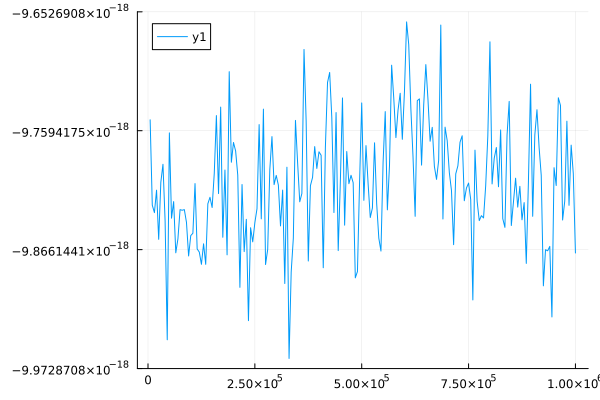

In [4]:
plot(steps, e_tot)

In [4]:
@benchmark total_energy(Simulation)

BenchmarkTools.Trial: 120 samples with 1 evaluation.
 Range (min … max):  35.744 ms … 54.374 ms  ┊ GC (min … max): 8.45% … 7.27%
 Time  (median):     41.034 ms              ┊ GC (median):    8.30%
 Time  (mean ± σ):   41.767 ms ±  3.203 ms  ┊ GC (mean ± σ):  8.82% ± 1.89%

           ▂  ▅▅▅▅▂█▂▄    ▁                                    
  ▃▁▁▁▁▁▅▅▃█▅███████████▆▅█▅▃▃▅▃▃▃▃▃▃▃▁▃▃▃▁▁▃▅▁▁▁▁▁▁▁▁▃▁▃▁▁▁▃ ▃
  35.7 ms         Histogram: frequency by time        53.5 ms <

 Memory estimate: 46.02 MiB, allocs estimate: 32378.

In [5]:
@benchmark single_energy(2, Simulation, false)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  32.100 μs …   4.338 ms  ┊ GC (min … max): 0.00% … 97.92%
 Time  (median):     44.200 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   52.830 μs ± 135.763 μs  ┊ GC (mean ± σ):  9.31% ±  3.63%

  █▇▅▄▃▃▃▄▆▇▅▃▂▂▁ ▁ ▁▁▁▁▁        ▁▂▂▁                          ▂
  ███████████████████████████▇▇▇██████▆▆▆▅▄▆▅▆▆▅▆▅▆▆▆▆▅▆▅▅▅▂▄▄ █
  32.1 μs       Histogram: log(frequency) by time       141 μs <

 Memory estimate: 65.91 KiB, allocs estimate: 32.